# Construction d'un modèle de classification des radios

## Imports des modules utilisés

In [1]:
import numpy as np
import pandas as pd

# Gestion des fichiers
import os
import sys
import io

# Gestion des images
from PIL import Image, ImageFilter, ImageStat
import cv2

import matplotlib.pyplot  as plt
from matplotlib import style
%matplotlib inline

# Barre de progression
from tqdm import tqdm

# Imports pour la mise en place du réseau de neuronnes
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16, VGG19, Xception, ResNet50V2, DenseNet201
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [ ]:
# Définition des répertoires de données sous Colab ou en Local

# Google Colab : Permet de faire le lien avec le drive où sont stockées les images
try:
    from importlib.util import find_spec
    find_spec('google')
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Colab Notebooks/radio-covid19/notebooks')

    # Import des fichiers images zippés et décompression sous Colab
    # Permet d'accélérer les temps de traitements
    import zipfile
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/radio-covid19/data/zips/COVID.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/radio-covid19/data/zips/Viral Pneumonia.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/radio-covid19/data/zips/Normal.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/radio-covid19/data/zips/Lung_Opacity.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    # Chemins vers les dossiers d'images et des masks
    data_folders_path = ['/content/data/COVID/', '/content/data/Lung_Opacity/', '/content/data/Normal/', '/content/data/Viral Pneumonia/']

    # Ajoute le chemin vers le dossier des notebooks dans le PATH
    # pour pouvoir faire l'import de radiocovid.py dans Colab
    sys.path.append('/content/drive/MyDrive/Colab Notebooks/radio-covid19/notebooks')


# Exécution en local
except ImportError:
    # Chemins vers les dossiers d'images et des masks
    data_folders_path = ['../data/COVID/', '../data/Lung_Opacity/', '../data/Normal/', '../data/Viral Pneumonia/']


Mounted at /content/drive


## Paramètres du modèle

In [ ]:
# Paramètres
IMG_SHAPE = (256, 256)  # Taille des images/masques
BATCH_SIZE = 32         # Taille des batchs TensorFlow
SEED = 77               # Permet d'assurer une homogénéité dans les mélanges/transformations des datasets
NB_IMAGES = 12000       # Nombre d'images à sélectionner pour constituer le dataset
TEST_SIZE = 0.2         # Taux d'images utilisées pour le jeu de test

# Paramètres de préprocessing
PREPROCESS_CROPPING = True              # True|False
PREPROCESS_MASKING  = 'special'         # True|False|'special'
PREPROCESS_EGALISATION = 'CLAHE'

# Paramètres du modele
MODEL_CORE_MODEL = 'VGG16'              # 'VGG16'|'VGG19'|'Xception'|'ResNet50V2'|'DenseNet201'
# MODEL_ADD_AUGMENTATION
# Si `True`, des layers d'augmentation sont ajoutés
# Si l'échantillon dépasse 6.000 images, cela signifie quedes images auront été sélectionnées plusieurs fois
# une augmentation sera donc automatiquement ajoutée
MODEL_ADD_AUGMENTATION = True    # True|False

## Construction jeux de données

In [ ]:
# Liste les fichiers existants dans un DataFrame

# Initialise des listes vides pour stocker les chemins des images et des masques
input_img_paths = []
masks_img_paths = []

# Parcourt chaque dossier
for folder in data_folders_path:
    img_folder = os.path.join(folder,'images')
    masks_folder = os.path.join(folder,'masks')

    # Récupére les chemins des images
    img_paths = sorted([
        os.path.join(img_folder, fname)
        for fname in os.listdir(img_folder)
        if fname.endswith(".png")])

    # Récupére les chemins des masques
    masks_paths = sorted([
        os.path.join(masks_folder, fname)
        for fname in os.listdir(masks_folder)
        if fname.endswith(".png")])

# Ajoute les chemins des images et des masques aux listes correspondantes
    input_img_paths.extend(img_paths)
    masks_img_paths.extend(masks_paths)

# Créé un DataFrame à partir des listes de chemins
df_all = pd.DataFrame({'image_path': input_img_paths, 'mask_path': masks_img_paths})

In [ ]:
# Création de la colonne 'target'
labels=["COVID", "Normal", "Viral Pneumonia", "Lung_Opacity"]
for label in labels:
    df_all.loc[df_all['image_path'].str.contains(label), "target"] = label

# Ajout de la colonne 'COVID' qui sera utilisée lors de la classification binaire (Covid / Pas_Covid)
# objectif du projet
df_all['COVID'] = (df_all['target']=='COVID').astype('int')

# Affiche un extrait du DataFrame contruit
df_all

### Séparation jeu d'entraînement / jeu de test

In [ ]:
# Les radios COVID sont minoritaires donc, on ajoute une probabilité plus grande
# d'avoir des images COVID dans le jeu de train/test.
# L'objectif est d'avoir environ 50% d'images COVID dans le dataset
df_all['weights'] = ((df_all['target']=='COVID') * 6) + ((df_all['target']=='Lung_Opacity') * 0.5) + 1

# Récupère un jeu d'images pour le jeu de test
df_test = df_all.sample(int(NB_IMAGES * TEST_SIZE), weights=df_all['weights'], random_state=SEED)
df_test.drop('weights', axis=1, inplace=True)

# Récupère un jeu d'images pour le jeu d'entraînement
# en retirant les images déjà prises par le jeu de test.
# Les images pourront être sélectionnées plusieurs fois pour correspondre au nombre d'image souhaité
# des calques de préprocessing seront ajoutés au début du modèle pour que les images prises
# plusieurs fois ne soient pas identiques.
df_train = df_all[~df_all.index.isin(df_test.index)].sample(int(NB_IMAGES * (1-TEST_SIZE)), weights=df_all['weights'], replace=True, random_state=SEED)
df_train.drop('weights', axis=1, inplace=True)

In [ ]:
print("Jeu d'entraînement :")
print("--------------------")
print("- Nbre d'images :", len(df_train))
print("- Répartition par type :")
# Affiche le ratio d'images par type
display(df_train['target'].value_counts(normalize=True))
display(df_train.head(3))

print("\nJeu de test :")
print("--------------------")
print("- Nbre d'images :", len(df_test))
print("- Répartition par type :")
# Affiche le ratio d'images par type
display(df_test['target'].value_counts(normalize=True))
display(df_test.head(3))

In [ ]:
# Séparation des données
X_train_path = df_train.drop(['COVID'],axis=1)
y_train      = df_train['COVID']
X_test_path  = df_test.drop(['COVID'],axis=1)
y_test       = df_test['COVID']

In [ ]:
# Vérifie qu'aucune image du jeu de test soit également dans le jeu d'entraînement
print("Nombre d'images du jeu de test présentes dans le jeu d'entraînement", X_test_path.index.isin(X_train_path.index).sum())

## Préprocessing des données

Réutilisation de la fonction de preprocessing définie dans le notebook "Pre-processing".

**Modification**

Ajout de la possibilité d'utiliser le modèle de prédiction des masques

In [ ]:

# Définition d'une fontion de pré-processing
def preprocessing (image_path, mask_path, masking=False, cropping=False):
    """Cette fonction réalise:
       - le Redimensionnement de l'image
       - Suppression des éventuels cadres noirs
       - Application du masque
       - Suppression des annotations
       - Egalisation des histogrammes
       - Application du Gaussian Blur
       - Normalisation

    Paramètres
    ----------
    image_path : str
        - Url du image à pré-traiter
    mask_path : str|tf.keras.models.Model
        - Si `str`   : Url du masque de l'image
        - Si `Model` : Modèle à utiliser pour prédire le masque
    masking = `False` :
        Si `False`,  le masque ne sera pas appliqué
        Si `True`, le masque sera appliqué
        Si `special`, un masque spécifique sera calculé qui conserve le centre
        des poumons.
    cropping = `False`
        Si `False`, l'image ne sera pas recadrée
        Si `True`, l'image sera recadrée autour de la région pulmonaire

    Retourne
    --------
    - image pré-processée

    """

    # Chargement des images et des masks
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Si mask_path est un modèle
    if isinstance(mask_path, tf.keras.models.Model):
        # Calcule le masque en uilisant le modèle
        i = image.astype('uint8')
        i = cv2.resize(i, (256,256))
        i = cv2.equalizeHist(i)
        i = cv2.GaussianBlur(i, ksize=(5,5), sigmaX=0)

        i = i.reshape(1,256,256,1)
        mask = mask_path(i)
        mask = mask.numpy().reshape(256,256)

    # Sinon, considère que mask_path est l'url de l'image du masque
    else:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Redimensionnement de l'image
    image = cv2.resize(image, dsize=IMG_SHAPE)
    mask  = cv2.resize(mask, dsize=IMG_SHAPE)

    # Suppression des éventuels cadres noirs
    # Récupère les indices des pixels <> 0
    X, Y = image.nonzero()
    # Fixe une limite de cadre
    # pour éviter de redimensionner toutes les images pour un bord de 1 px
    if (X.min() < 5) and (X.max() > 250) and (Y.min() < 5) and (Y.max() > 250):
        pass
    else:
        # Les valeurs min et max peuvent être utilisées pour déterminer la région qui comporte la radio
        roi_img = image[X.min():X.max(), Y.min():Y.max()]
        roi_msk = mask[X.min():X.max(), Y.min():Y.max()]
        image  = cv2.resize(roi_img, dsize=IMG_SHAPE)
        mask = cv2.resize(roi_msk, dsize=IMG_SHAPE)

    # Appliquer le masque
    if masking==True:
        image = image & mask

    if masking=='special':
        # Pour chaque ligne de l'image
        for l in range(0, IMG_SHAPE[0]):
            non_vides = mask[l,:].nonzero()[0]
            if len(non_vides)==0:
                image[l,:]=0
            else:
                if non_vides.min() > 0:
                    image[l, :non_vides.min() - 1] = 0
                if non_vides.max() < IMG_SHAPE[1]:
                    image[l, non_vides.max() + 1:IMG_SHAPE[1]] = 0

    # Recadrer sur la région pulmonaire
    if cropping:
        X, Y = mask.nonzero()
        roi_msk   = mask[X.min():X.max(), Y.min():Y.max()]
        roi_img   = image[X.min():X.max(), Y.min():Y.max()]
        mask   = cv2.resize(roi_msk, dsize=IMG_SHAPE)
        image  = cv2.resize(roi_img, dsize=IMG_SHAPE)

    # Suppression des annotations
    (_, img) = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    inpaint_mask = cv2.drawContours(img, contours=contours, contourIdx=-1, color=255, thickness=12)
    # Remplace les zones annotées
    image = cv2.inpaint(image, inpaint_mask, inpaintRadius=2, flags=cv2.INPAINT_TELEA)

    # Egalisation
    # image=cv2.equalizeHist(image)
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=64, tileGridSize=(8,8))
    image = clahe.apply(image)

    """
    if masking=='special':
        # Pour chaque ligne de l'image
        for l in range(0, IMG_SHAPE[0]):
            non_vides = mask[l,:].nonzero()[0]
            if len(non_vides)==0:
                image[l,:]=0
            else:
                if non_vides.min() > 0:
                    image[l, :non_vides.min() - 1] = 0
                if non_vides.max() < IMG_SHAPE[1]:
                    image[l, non_vides.max() + 1:IMG_SHAPE[1]] = 0
    """

    # Gaussian Blur
    # image=cv2.GaussianBlur(image, ksize=(5,5), sigmaX=0)

    # Repasse l'image en 3 couches pour correspondre aux modèles préentrainés utilisés
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Etape finale de preprocessing selon le type de Core Model utilisé
    if MODEL_CORE_MODEL == 'VGG16':
        image = tf.keras.applications.vgg16.preprocess_input(image)
    elif MODEL_CORE_MODEL == 'VGG19':
        image = tf.keras.applications.vgg19.preprocess_input(image)
    elif MODEL_CORE_MODEL == 'Xception':
        image = tf.keras.applications.xception.preprocess_input(image)
    elif MODEL_CORE_MODEL == 'ResNet50V2':
        image = tf.keras.applications.resnet_v2.preprocess_input(image)
    elif MODEL_CORE_MODEL == 'DenseNet201':
        image = tf.keras.applications.densenet.preprocess_input(image)
    else:
        # Normalisation
        image = image / 255

    return image

In [ ]:
# Définition d'une fontion de pré-processing
def preprocessing (image_path, mask_path,
                   masking=False,
                   cropping=False,
                   normalisation=MODEL_CORE_MODEL,
                   egalisation=PREPROCESS_EGALISATION):
    """Cette fonction réalise:
       - le Redimensionnement de l'image
       - Suppression des éventuels cadres noirs
       - Application du masque
       - Suppression des annotations
       - Egalisation des histogrammes
       - Application du Gaussian Blur
       - Normalisation

    Paramètres
    ----------
    image_path : str
        - Url du image à pré-traiter
    mask_path : str|tf.keras.models.Model
        - Si `str`   : Url du masque de l'image
        - Si `Model` : Modèle à utiliser pour prédire le masque
    masking = `False` :
        Si `False`,  le masque ne sera pas appliqué
        Si `True`, le masque sera appliqué
        Si `special`, un masque spécifique sera calculé qui conserve le centre
        des poumons.
    cropping = `False`
        Si `False`, l'image ne sera pas recadrée
        Si `True`, l'image sera recadrée autour de la région pulmonaire

    Retourne
    --------
    - image pré-processée

    """

    # Chargement des images et des masks
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Si mask_path est un modèle
    if isinstance(mask_path, tf.keras.models.Model):
        # Calcule le masque en uilisant le modèle
        i = image.astype('uint8')
        i = cv2.resize(i, (256,256))
        i = cv2.equalizeHist(i)
        i = cv2.GaussianBlur(i, ksize=(5,5), sigmaX=0)

        i = i.reshape(1,256,256,1)
        mask = mask_path(i)
        mask = tf.cast(mask > 0.5, 'float32')
        mask = mask.numpy().reshape(256,256)

    # Sinon, considère que mask_path est l'url de l'image du masque
    else:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Si masking 'special',
    # modifie le masque pour conserver la partie centrale des poumons
    if masking == 'special':
        # Pour chaque ligne de l'image
        for l in range(0, mask.shape[0]):
            # Récupère les index différents de zéro
            non_vides = mask[l,:].nonzero()[0]
            # Colorie les valeurs extrêmes avec du blanc pour garder le centre des poumons
            if len(non_vides) != 0:
                mask[l, non_vides.min():non_vides.max()] = mask.max()

    # Redimensionnement de l'image et du masque
    image = cv2.resize(image, dsize=IMG_SHAPE)
    mask  = cv2.resize(mask, dsize=IMG_SHAPE)

    # Suppression des éventuels cadres noirs
    # Récupère les indices des pixels <> 0
    X, Y = image.nonzero()
    # Fixe une limite de cadre
    # pour éviter de redimensionner toutes les images pour un bord de 1 px
    if (X.min() < 5) and (X.max() > 250) and (Y.min() < 5) and (Y.max() > 250):
        pass
    else:
        # Les valeurs min et max peuvent être utilisées pour déterminer la région qui comporte la radio
        roi_img = image[X.min():X.max(), Y.min():Y.max()]
        roi_msk = mask[X.min():X.max(), Y.min():Y.max()]
        image  = cv2.resize(roi_img, dsize=IMG_SHAPE)
        mask = cv2.resize(roi_msk, dsize=IMG_SHAPE)

    # Appliquer le masque
    if masking!=False:
        image = image & mask

    # Recadrer sur la région pulmonaire
    if cropping:
        X, Y = mask.nonzero()
        roi_msk   = mask[X.min():X.max(), Y.min():Y.max()]
        roi_img   = image[X.min():X.max(), Y.min():Y.max()]
        mask   = cv2.resize(roi_msk, dsize=IMG_SHAPE)
        image  = cv2.resize(roi_img, dsize=IMG_SHAPE)

    # Suppression des annotations
    (_, img) = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    inpaint_mask = cv2.drawContours(img, contours=contours, contourIdx=-1, color=255, thickness=12)
    # Remplace les zones annotées
    image = cv2.inpaint(image, inpaint_mask, inpaintRadius=2, flags=cv2.INPAINT_TELEA)

    # Egalisation
    if egalisation is True:
        image=cv2.equalizeHist(image)
    elif egalisation == 'CLAHE':
        # create a CLAHE object (Arguments are optional).
        clahe = cv2.createCLAHE(clipLimit=64.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        # Réapplique le masque pour que les zones noires restent bien noire
        if masking != False:
            image = image & mask

    # Gaussian Blur
    # image=cv2.GaussianBlur(image, ksize=(5,5), sigmaX=0)

    # Repasse l'image en 3 couches pour correspondre aux modèles préentrainés utilisés
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Etape finale de preprocessing selon le type de Core Model utilisé
    if normalisation == 'VGG16':
        image = tf.keras.applications.vgg16.preprocess_input(image)
    elif normalisation == 'VGG19':
        image = tf.keras.applications.vgg19.preprocess_input(image)
    elif normalisation == 'Xception':
        image = tf.keras.applications.xception.preprocess_input(image)
    else:
        # Normalisation
        image = image / 255

    return image

### Préparation du jeu de test

In [ ]:
# Le jeu de test n'étant pas volumineux, peut être chargé en mémoire

# Charge les images de X_test_path pré-processées en mémoire dans la variable X_test.
X_test=[]
for im_path,msk_path in tqdm(zip(X_test_path["image_path"],X_test_path["mask_path"])):
    masked_image = preprocessing(im_path, msk_path, masking=PREPROCESS_MASKING, cropping=PREPROCESS_CROPPING)
    masked_image = tf.convert_to_tensor(masked_image)
    X_test.append(masked_image)

# Transformation en tenseurs
X_test = tf.concat(X_test, axis=0)
X_test = tf.reshape(X_test, (len(X_test_path), IMG_SHAPE[0], IMG_SHAPE[1], 3))

In [ ]:
# Affichage d'un exemple d'image du jeu de test

def deprocess_image(x):
    """ Re-normalise l'image pour qu'elle puisse être affichée.
    Le preprocessing VGGxx et Xception décalent les couches des images.
    """
    # Min-max
    x = 255 * (x - x.min()) / (x.max()-x.min())
    return x.astype('uint8')

# Rescale de l'image qui a été préprocessée avec un scaling propre au modèle utilisé
img = deprocess_image(X_test[9].numpy())

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Image de test préprocessée')
plt.show()

### Préparation du jeu d'entraînement

La taille du jeu d'entraînement est importante, il sera traité à l'aide de TensorFlow.

In [ ]:
# Définition d'une fonction qui permet de pré-processer les images et les générer
@tf.py_function(Tout=tf.float32)
def load_image_and_preprocessing(image_path, mask_path):
    masked_image = preprocessing(image_path.numpy().decode("utf-8"), mask_path.numpy().decode("utf-8"), masking=PREPROCESS_MASKING, cropping=PREPROCESS_CROPPING)
    masked_image = tf.convert_to_tensor(masked_image)
    return masked_image

In [ ]:
# Définit un dataset de la forme (url image, url mask, classe)...
dataset_images = tf.data.Dataset.from_tensor_slices((list(X_train_path['image_path']), list(X_train_path['mask_path']), y_train))

# ...et le transforme en un dataset de la forme (image masquée, classe) grâce à la méthode `map()`
dataset_masked_images = dataset_images.map(lambda x,y,z : [load_image_and_preprocessing(x,y),z], num_parallel_calls=-1).batch(32)

In [ ]:
# Affichage d'une image du Dataset en exemple

# Rescale de l'image qui a été préprocessée avec un scaling propre au modèle utilisé
img = deprocess_image(list(dataset_masked_images.take(1))[0][0][0].numpy())

plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Image du jeu d'entraînement préprocessée")
plt.show()

## Préparation du modèle sur une base VGG19

### Contruction du modèle

Un modèle séquentiel sera construit sur la base d'un modèle VGG16 dont seul le dernier layer sera entrainable.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = Sequential(name='RadioCovid19')

model.add(Input((IMG_SHAPE[0], IMG_SHAPE[1], 3),BATCH_SIZE))


# Ajout de couches d'augmentation ----------------------------------------------
if (MODEL_ADD_AUGMENTATION) or (NB_IMAGES > 6000):
    model.add(RandomRotation((-0.05, 0.05), seed=SEED))
    model.add(RandomZoom((-0.05, 0), seed=SEED))
    model.add(RandomTranslation(width_factor=(0,0), height_factor=(-0.125, 0.125), seed=SEED))
    # model.add(RandomBrightness(factor=(-0.25,0.25), value_range=[tf.reduce_min(X_test), tf.reduce_max(X_test)]))
    # model.add(RandomFlip(mode='horizontal')) # Non, pas de flip pour des radios. Rare que les radios soient à l'envers.


# Ajouter le core model choisi au modèle séquentiel ----------------------------
if MODEL_CORE_MODEL=='VGG16':
    cm = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))
    # Bloquage du blackbone, sauf pour le dernier layer de convolution
    for layer in cm.layers[:-4]:
        layer.trainable = False
    model.add(cm)
    cm.summary()

elif MODEL_CORE_MODEL=='VGG19':
    cm = VGG19(include_top=False, weights="imagenet", input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))
    # Bloquage du blackbone, sauf pour le dernier layer de convolution
    for layer in cm.layers[:-2]:
        layer.trainable = False
    model.add(cm)
    cm.summary()

elif MODEL_CORE_MODEL=='Xception':
    cm = Xception(include_top=False, weights="imagenet", input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))
    # Bloquage du blackbone du Xception
    for layer in cm.layers[:-6]:
        layer.trainable = False
    for layer in cm.layers[-6:]:
        if isinstance(layer, BatchNormalization):
            layer.trainable = False
    model.add(cm)
    cm.summary()

elif MODEL_CORE_MODEL=='ResNet50V2':
    cm = ResNet50V2(include_top=False, weights="imagenet", input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))

    for layer in cm.layers:
        if (layer.name[0:6]!='conv5_'):
            layer.trainable = False
        if isinstance(layer, BatchNormalization):
            layer.trainable = False

    model.add(cm)
    cm.summary()

elif MODEL_CORE_MODEL=='ResNet152V2':
    cm = ResNet50V2(include_top=False, weights="imagenet", input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))

    for layer in cm.layers:
        if (layer.name[0:12]!='conv5_block3'):
            layer.trainable = False
        if (layer.name == 'post_relu'):
            layer.trainable = False
        if isinstance(layer, BatchNormalization):
            layer.trainable = False

    model.add(cm)
    cm.summary()

elif MODEL_CORE_MODEL=='DenseNet201':
    cm = DenseNet201(include_top=False, weights="imagenet", input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))

    for layer in cm.layers:
        if (layer.name[0:11]!='conv5_block'):
            layer.trainable = False
        if isinstance(layer, BatchNormalization):
            layer.trainable = False

    model.add(cm)
    cm.summary()



# Ajout des dernières couches --------------------------------------------------
# Dans le cas d'un modèle pour GRADCAM
# if MODEL_FOR_GRADCAM:
#     model.add(MaxPooling2D((1,1), name='last-layer'))
#     model.add(Flatten())
#     model.add(Dropout(0.5))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(2, activation='softmax'))
# else:

model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


# Affichage du résumé du modèle construit --------------------------------------
model.summary()

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), 'sparse_categorical_crossentropy', metrics=['accuracy'])

### Définition de fonctions de Callback

In [ ]:
from tensorflow.keras import callbacks

# Savegarde automatique des poids
checkpoint = callbacks.ModelCheckpoint(filepath='checkpoint',
                                       monitor='val_loss',
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='min',
                                       save_freq='epoch')

# Réduction automatique du taux d'apprentissage
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         patience=2,
                                         factor=0.1,
                                         verbose=2,
                                         mode='min')

# Arrêt de l'entraînement si plus aucun progres n'est constaté sur le jeu de test
early_stopping = callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=3,
        verbose=2,
        restore_best_weights=True
        )


### Entraînement du modèle

In [ ]:
history = model.fit(dataset_masked_images, epochs=32, validation_data=(X_test, y_test), callbacks=[lr_plateau, early_stopping])

**Perte et accuracy**

In [ ]:
import pickle

fic = open('../data/models/history_VGG16.pickle', 'wb')
pickle.dump(history, fic)
fic.close()

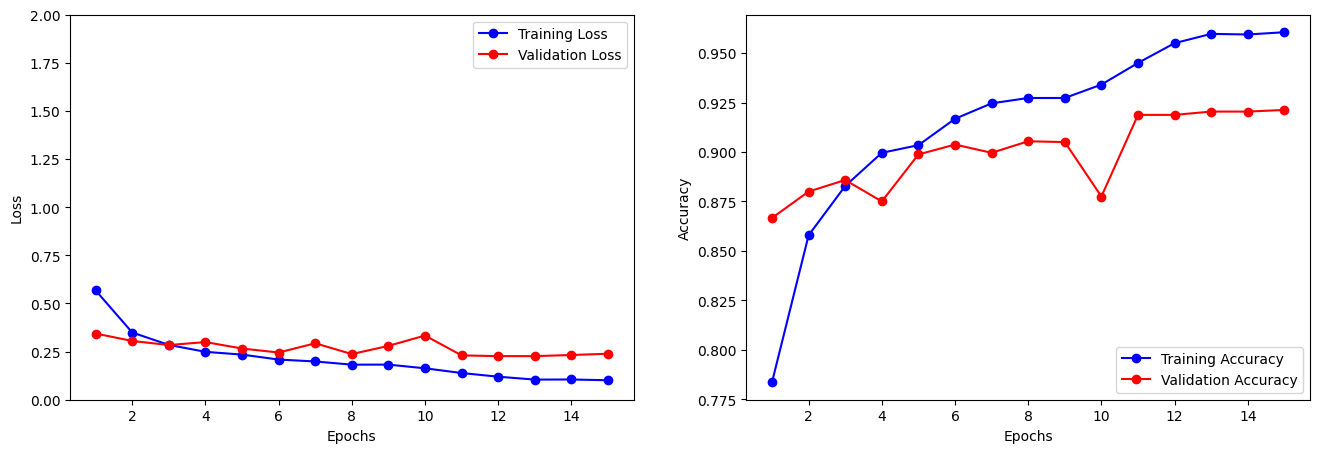

In [ ]:
# Courbes de perte et d'accuracy

plt.figure(figsize = (16,5))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Courbe de perte
plt.subplot(121)
plt.plot(epochs, train_loss, 'b-o', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r-o',  label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

# Courbe d'accuracy
plt.subplot(122)
plt.plot(epochs, train_acc, 'b-o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

In [ ]:
# Sauvegarde du modèle entraîné
model.save(f"../data/models/classification_{MODEL_CORE_MODEL}_{PREPROCESS_MASKING}_{PREPROCESS_CROPPING}_clahe")

## Analyse des performances du modèle

In [ ]:
# Chargement du modèle
model = tf.keras.saving.load_model(f"../data/models/classification_{MODEL_CORE_MODEL}_{PREPROCESS_MASKING}_{PREPROCESS_CROPPING}_clahe")

**Calcul des probabilités du modèle**

In [ ]:
# Probabilités renvoyées par le modèle
y_prob = model.predict(X_test, batch_size=32)

63/63 [==============================] - 1416s 22s/step


### Calcul du seuil optimal de détection des cas COVID

La valeur de seuil qui permet une prédiction optimale entre NonCovid/Covid est : 0.50093096 




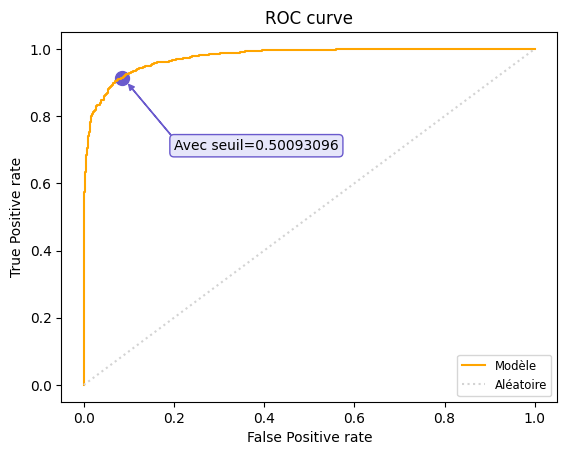

In [ ]:
from sklearn.metrics import roc_curve

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test.values, y_prob[:,1])

# Calcul de la valeur de seuil qui permet :
# de maximiser le taux de vrais positifs
# en minimisant le taux de faux négatifs
thresh_curve = (tpr-(1-fpr))**2
idTresh = thresh_curve.argmin()
thresh = thresholds[idTresh]

print("La valeur de seuil qui permet une prédiction optimale entre NonCovid/Covid est :", thresh, "\n\n")

plt.plot(fpr, tpr, label='Modèle', color='orange')

# Ajoute la ligne du hasard dans le graph
plt.plot((0,1), (0,1), linestyle=':', color='lightgray', label='Aléatoire')

# Ajoute le point qui correspond à la valeur de seuil
plt.scatter(fpr[idTresh], tpr[idTresh], color='slateblue', marker='o', s=100)
plt.annotate('Avec seuil='+str(thresh),
             xy=(fpr[idTresh]+0.015, tpr[idTresh]-0.02),
             xytext=(0.2,0.7),
             bbox=dict(boxstyle="round", facecolor='lavender', edgecolor='slateblue'),
             arrowprops=dict(color='slateblue', width=0.25, headwidth=4, headlength=4),
             )

plt.ylabel('True Positive rate')
plt.xlabel('False Positive rate')

plt.title('ROC curve')
plt.legend(fontsize='small')
plt.show()

In [ ]:
# Prédiction de la classe avec argmax (seuil=0.5)
# y_pred = tf.argmax(y_prob, axis=-1).numpy()

# Prédiction de la classe avec la valeur de seuil fixée
y_pred = tf.cast(y_prob[:,1] > thresh, tf.int32)

**Tableau récapitulatif**

In [ ]:
# Contruction d'un tableau récapitulatif du jeu de tests est des résultats
df_recap = X_test_path.copy()

df_recap['type'] = df_all.loc[X_test_path.index, 'target']
df_recap['true'] = y_test.values
df_recap['pred'] = y_pred
df_recap['covid_prob'] = np.round(y_prob[:,1],2)

# Réindexe le df
df_recap.reset_index(drop=False, names='old_index', inplace=True)

df_recap[0:10]

,old_index,image_path,mask_path,target,type,true,pred,covid_prob
0,17454,/content/data/Normal/images/Normal-787.png,/content/data/Normal/masks/Normal-787.png,Normal,Normal,0,0,0.12
1,6378,/content/data/Lung_Opacity/images/Lung_Opacity...,/content/data/Lung_Opacity/masks/Lung_Opacity-...,Lung_Opacity,Lung_Opacity,0,1,0.70
2,9868,/content/data/Normal/images/Normal-1040.png,/content/data/Normal/masks/Normal-1040.png,Normal,Normal,0,0,0.00
3,912,/content/data/COVID/images/COVID-182.png,/content/data/COVID/masks/COVID-182.png,COVID,COVID,1,1,1.00
4,572,/content/data/COVID/images/COVID-1513.png,/content/data/COVID/masks/COVID-1513.png,COVID,COVID,1,0,0.48
5,11441,/content/data/Normal/images/Normal-2457.png,/content/data/Normal/masks/Normal-2457.png,Normal,Normal,0,0,0.00
6,2137,/content/data/COVID/images/COVID-2922.png,/content/data/COVID/masks/COVID-2922.png,COVID,COVID,1,1,0.94
7,3545,/content/data/COVID/images/COVID-935.png,/content/data/COVID/masks/COVID-935.png,COVID,COVID,1,1,1.00
8,1574,/content/data/COVID/images/COVID-2415.png,/content/data/COVID/masks/COVID-2415.png,COVID,COVID,1,1,1.00
9,3573,/content/data/COVID/images/COVID-960.png,/content/data/COVID/masks/COVID-960.png,COVID,COVID,1,1,0.98


### Matrices de confusion

**Globale**

In [ ]:
mc = pd.crosstab(df_recap['true'], df_recap['pred'], rownames=['classes réelles'], colnames=['classes prédites'])

# Mise en forme
mc_styled = mc.style
mc_styled

mc_styled.set_table_styles([
    {'selector': '.good', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.bad',  'props': 'background-color: #ffe6e6;'}], overwrite=False)
classname = pd.DataFrame([['good ', 'bad'],
                          ['bad ', 'good']],
                         index=mc.index,
                         columns=mc.columns)
mc_styled.set_td_classes(classname)
mc_styled


classes prédites,0,1
classes réelles,,
0,851,98
1,107,944


**Spécifiques**

In [ ]:
# Calcule la matrice de confusion
ct = pd.crosstab(df_recap['type'], df_recap['pred'].replace({0:'Non-covid', 1:'COVID'}) , rownames=['Type Radio'], colnames=['classes prédites'], normalize='index')

# Mise en forme
ct_styled = ct.style
ct_styled.format('{:.0%}', precision=2)
ct_styled.set_table_styles([
    {'selector': '.good', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.bad',  'props': 'background-color: #ffe6e6;'}], overwrite=False)
classname = pd.DataFrame([['good ', 'bad'],
                          ['bad ', 'good'],
                          ['bad ', 'good'],
                          ['bad ', 'good']],
                         index=ct.index,
                         columns=ct.columns)
ct_styled.set_td_classes(classname)
ct_styled


classes prédites,COVID,Non-covid
Type Radio,,
COVID,90%,10%
Lung_Opacity,12%,88%
Normal,10%,90%
Viral Pneumonia,0%,100%


### Autres métriques

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_recap['true'], df_recap['pred']))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       949
           1       0.91      0.90      0.90      1051

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



### Exemples de prédictions

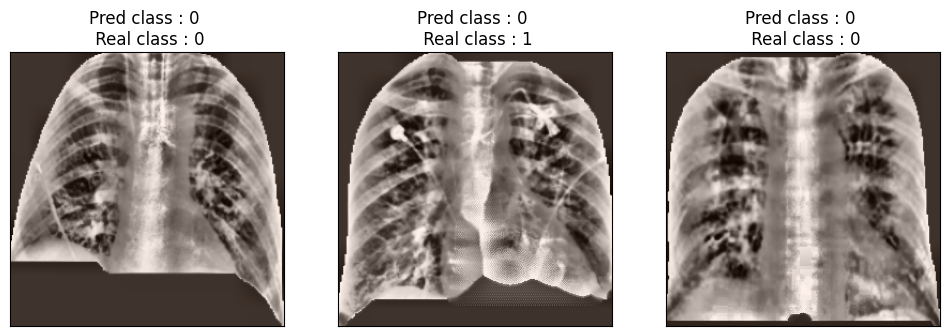

In [ ]:
indices_random = tf.random.uniform([3], 0, len(X_test), dtype=tf.int32)

plt.figure(figsize=(12,6))
for i, idx in enumerate(indices_random):

    # Rescale de l'image qui a été préprocessée avec un scaling propre au modèle utilisé
    img = deprocess_image(X_test[idx].numpy())

    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title('Pred class : {} \n Real class : {}'.format(df_all.COVID.unique()[y_pred[idx]], df_all.COVID.unique()[y_test.values[idx]]))

## Interpretation

### Définition d'une fonction de Génération de la HeatMap

**Modification**

Ajout de la possibilité de prendre en compte la valeur de la prédiction pour pondérer la gradCam

In [ ]:
def gradCam(image : tf.Tensor,
            model : tf.keras.Model,
            core_model_layername : str,
            last_conv_layername : str,
            pred_index : int|None = None,
            weighted_by_pred : bool = False):
    """Génère une heatmap des zones considérées comme importantes par le modèle

    Paramètres
    ----------
    image : tf.Tensor
        Image à traiter sous la forme d'un tenseur (1, height, width, channels)
        Le type de données doit être 'float32'
    model : tf.keras.Model
        Modèle utilisé pour la classification
    core_model_layername : str = MODEL_CORE_MODEL
        Permet de spécifier le nom d'un sous modèle imbriqué.
        Utile dans le cas où `last_conv_layer` appratient à un sous modèle
        imbriqué (layer de type `functional`)
    last_conv_layername : str|None = None
        Nom de la dernière couche de convolution du modèle.
        Si `None`, la fonction va rechercher le dernier calque
        de convolution du modèle.
    pred_index : int|None = None
        index de la classe à prédire.
        Si `None`, la heatmap retournée correspondra à la classe majoritaire
        calculée par le modèle
    weighted_by_pred : bool = False
        Si `True`, l'amplitude de la heatmap (0..255) sera pondérée
        par la valeur de la prédiction (0..1).
        Par exemple, si la valeur d'un pixel est 200 et que la valeur
        de la prédiction de la classe est 0.75, alors la valeur de ce pixel
        sera 200 x 0.75 = 150 et non 200.
        Cela permet d'éviter d'avoir une heatmap avec des valeurs extrêmes (255)
        si la prédiction de la classe n'est pas sûre (score proche de 0.5)

    Retourne
    --------
    Tuple contenant
    - Tableau numpy des points accordés à chaque pixel de l'image
    - Tableau des valeurs de prédiction
    """

    def get_layers(model) -> dict:
        """Retourne un dictionnaire {'nom layer':layer}
        des couches du modèle pasé en paramètre"""
        # liste toutes les couches du modèle
        layers = {}
        for l in model.layers:
            # Si la couche est un modèle
            if isinstance(l, tf.keras.Model):
                layers.update(get_layers(l))
            # Sinon, la couche est un calque
            else:
                layers[l.name] = l
        return layers

    # Récupère les couches du modèle ------------------------------------------
    layers = get_layers(model)
    last_conv_layer = layers[last_conv_layername]

    # Première étape, créer un nouveau modèle basé sur le modèle passé en paramètres
    # avec en retour : l'output du layer analysé, et l'output global du modèle (la prévision)
    # Si un 'core model' est utilisé (functionnal layer)
    # on fera d'abord appel au core model, puis le retour sera passé aux dernier
    # block du modèle général
    # modele : [VGG16][a][b] = [VGG16] puis [a][b] => [out]
    if core_model_layername is not None:
        core_model_layer = model.get_layer(core_model_layername)
        core_model = Model(core_model_layer.inputs, [last_conv_layer.output, core_model_layer.output])
        # Recherche le layer juste après le core_model_layername sélectionné
        n=[]
        for l in model.layers:
            n.append(l.name)
        # Reste du modèle sert à la classification
        clf_model = Model(model.get_layer(n[n.index(core_model_layername)+1]).input, [model.output])

    # Pas de Core Model
    else:
        # Modèle de classification
        clf_model = Model(model.inputs, [last_conv_layer.output, model.output])

    # Puis on calcule et récupère le gradient du calque surveillé et les prédictions du modèle
    with tf.GradientTape() as tape:

        # Si un core_model est déclaré
        if core_model_layername is not None:
            last_conv_layer_output, core_model_out = core_model(image, training=False)
            preds = clf_model(core_model_out, training=False)
        # Si pas de core model
        else:
            last_conv_layer_output, preds = clf_model(image, training=False)

        # S'il n'y a pas de classe particulière à surveiller,
        if pred_index is None:
            # On retourne les données de la classe déterminée par le modèle (classe majoritaire)
            pred_index = tf.argmax(preds[0])

        # Récupère la valeur de prédiction de la classe
        prediction = preds[:, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    class_grads = tape.gradient(prediction, last_conv_layer_output)

    # Discard batch dim
    last_conv_layer_output = tf.squeeze(last_conv_layer_output)
    class_grads = tf.squeeze(class_grads)
    norm_grads = tf.divide(class_grads, tf.reduce_mean(tf.square(class_grads)) + tf.keras.backend.epsilon())

    # Compute weights
    weights = tf.reduce_mean(norm_grads, axis=(0,1))
    cam = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=-1)

    # Apply reLU
    cam = np.maximum(cam, 0)

    if (np.max(cam) != 0):
        cam = cam / np.max(cam)

    # Resize heatmap to image size
    cam  = cv2.resize(np.uint8(255*cam), (image.shape[1], image.shape[1]), interpolation=cv2.INTER_CUBIC)

    # la heatmap est pondérée par le résultat de la prédiction
    if (weighted_by_pred):
        cam = cam * prediction.numpy()

    cam = np.uint8(cam)

    return cam, preds

### Création d'une fonction pour superposer l'image de la radio avec la heatmap

In [ ]:
def superimpose(image : np.ndarray, heatmap : np.ndarray, type='normal'):
    """Superpose un gradCam et une image pour facilier l'interprétation du modèle

    Paramètres
    ----------
    image : np.ndarray
        Image (width, height, 3) qui sera positionnée en arrière plan
    heatmap : np.ndarray
        heatmap (width, height) positionnée sur l'image.
    type : str = 'normal'
        Méthode de superposition d'image
         - 'normal'    : la heatmap est simplement superposée à l'image
         - 'emphasize' : la heatmat est retraitée pour  accentuer les zones
           les plus chaudes.
         - 'retangle' : créé des rectangles autour des zones les plus
            chaudes de la heatmap
    """
    # S'assure que la heatmap et l'image sont de même dimension
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Applique la transformation passée dans le paramètre `type`
    if type=='normal':
        cmap = cv2.COLORMAP_MAGMA

    elif type=='emphasize':
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        heatmap =  1 / (1 + np.exp(-50 * (heatmap-0.5)))
        cmap = cv2.COLORMAP_TURBO

    elif type=='rectangle':
        # Récupère les couleurs de la COLORMAP dans un tableau (256, 3)
        cmap = np.linspace(0,255,256, dtype='uint8')
        cmap = cv2.applyColorMap(cmap, cv2.COLORMAP_VIRIDIS)
        cmap = cv2.cvtColor(cmap, cv2.COLOR_BGR2RGB)
        cmap = cmap.reshape(256,3)
        color=tuple(map(int, cmap[heatmap.max()]))

        for thresh in [170, 100, 50]:
            _, threshold = cv2.threshold(heatmap, thresh=thresh, maxval=255, type=cv2.THRESH_BINARY)
            contours, _  = cv2.findContours(threshold, mode=cv2.RETR_LIST, method = cv2.CHAIN_APPROX_SIMPLE)
            for c in contours:
                x,y,w,h = cv2.boundingRect(c)
                image = cv2.rectangle(image, (x,y), ((x+w),(y+h)), color=color, thickness=2)
            if len(contours) > 0:
                break
        return image

    else:
        raise ValueError(f"Le paramètre `type` doit avoir la valeur 'normal', 'emphasize' ou 'rectange'. Reçu : '{type}'")

    # Passe la heatmap sous la forme d'une image 0..255
    if (heatmap.dtype.type is np.float_) and (0<=heatmap.max()<=1):
        heatmap = np.uint8(255 * heatmap)

    # Colorie la heatmap
    heatmap = cv2.applyColorMap(heatmap, cmap)

    # Finalement, superpose la heatmap avec l'image
    superimposed_img = heatmap * 0.7 + image
    superimposed_img = np.minimum(superimposed_img, 255).astype(np.uint8)
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img_rgb

### Affichage de radios et de leur heatmap

,old_index,image_path,mask_path,target,type,true,pred,covid_prob
3,912,/content/data/COVID/images/COVID-182.png,/content/data/COVID/masks/COVID-182.png,COVID,COVID,1,1,1.00
10,2624,/content/data/COVID/images/COVID-3360.png,/content/data/COVID/masks/COVID-3360.png,COVID,COVID,1,1,0.95
20,2963,/content/data/COVID/images/COVID-410.png,/content/data/COVID/masks/COVID-410.png,COVID,COVID,1,1,0.91
24,437,/content/data/COVID/images/COVID-1392.png,/content/data/COVID/masks/COVID-1392.png,COVID,COVID,1,1,1.00


tf.Tensor([2.3205162e-06 9.9999774e-01], shape=(2,), dtype=float32)


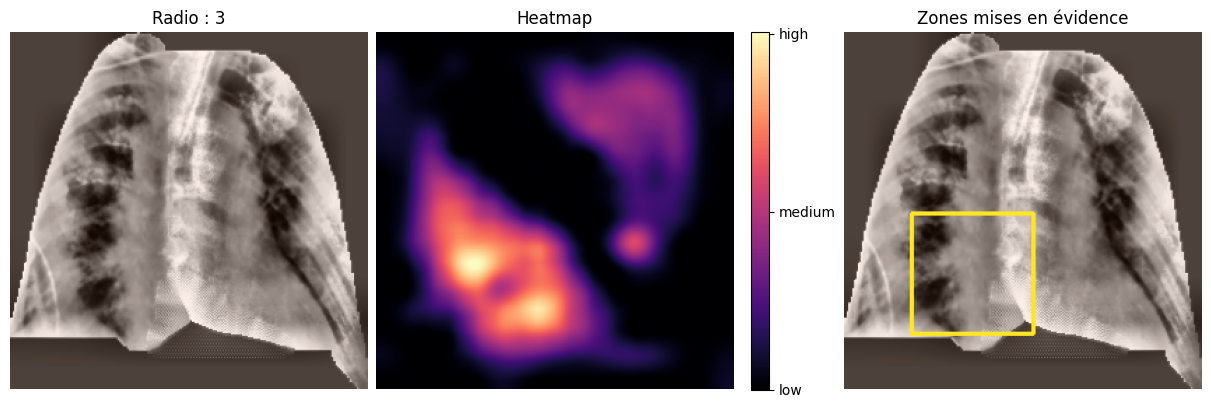

tf.Tensor([0.04551026 0.95448977], shape=(2,), dtype=float32)


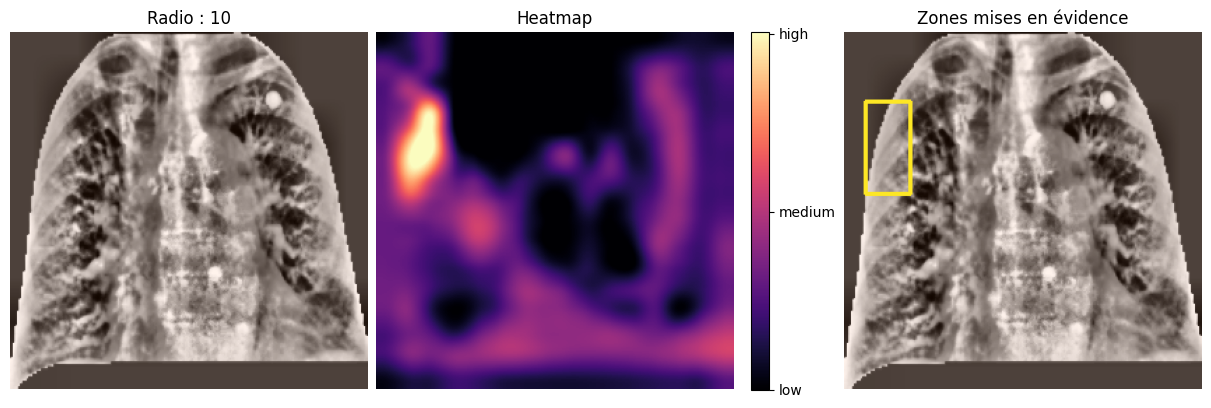

tf.Tensor([0.09216285 0.90783715], shape=(2,), dtype=float32)


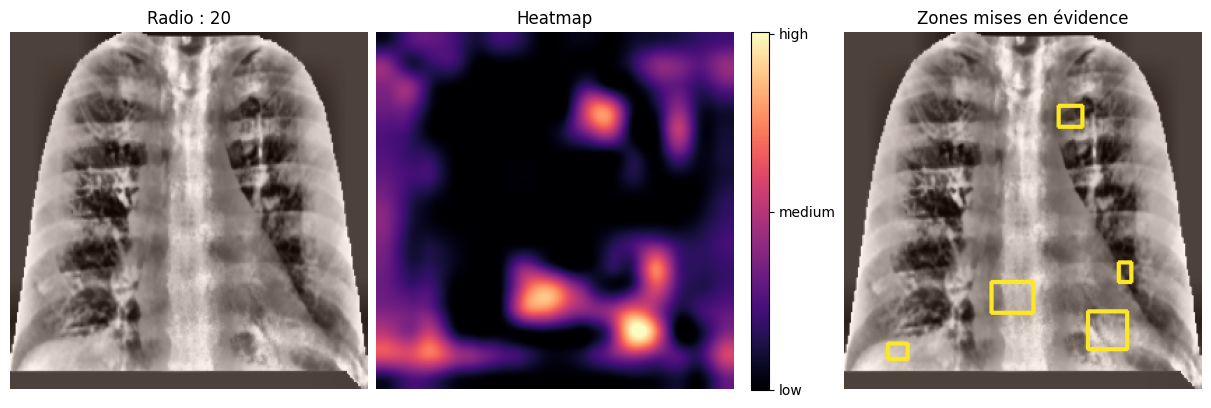

tf.Tensor([1.0577820e-04 9.9989426e-01], shape=(2,), dtype=float32)


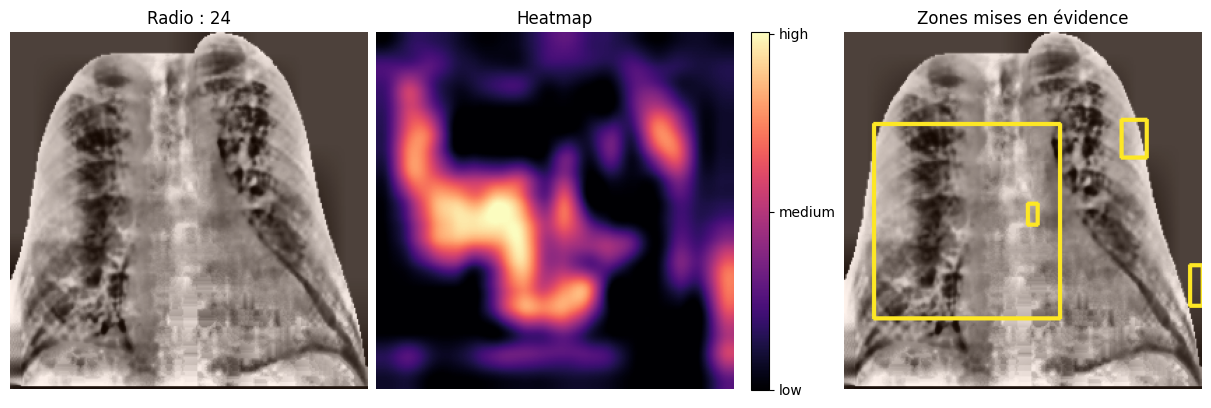

In [ ]:
# Prepare image
idx_img = [10, 20, 24, 31, 40, 43, 57, 58, 59, 63, 78, 80, 87, 90]
idx_img = [3, 10, 20, 24]
# idx_img = [10]

# Affichage de l'extrait du tableau
display(df_recap.loc[idx_img])

# Affiche l'image et sa heatmap
for i in idx_img:
    image = X_test[i].numpy()
    # image[32:224,32:224] = image.min()
    image = tf.expand_dims(image, axis=0)
    heatmap, preds = gradCam(image, model, core_model_layername='vgg16', last_conv_layername='block5_conv3')
    image = deprocess_image(tf.squeeze(image).numpy())

    print(preds[0])

    plt.figure(figsize=(12,4), layout='compressed')

    plt.subplot(131, title=f"Radio : {i}")
    plt.axis('off')
    plt.imshow(image, cmap='gray')

    plt.subplot(132, title='Heatmap')
    plt.axis('off')
    plt.imshow(heatmap, cmap='magma')

    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, 255, 127))
    cbar.ax.set_yticklabels(['low', 'medium', 'high'])

    plt.subplot(133, title='Zones mises en évidence')
    plt.axis('off')
    plt.imshow(superimpose(image, heatmap, 'rectangle'))

    plt.show()

## Tests divers

### Test avec un image COVID extérieure au dataset

In [ ]:
# Chargement de l'image
image = cv2.imread('../data/COVID/tests/b98508598396.png')
# Chargement du modèle de prédiction des masques
model_mask = tf.keras.saving.load_model('../data/models/mask_detection_20231130/')
# Preprocessing avec détection auto du masque
image_masquee = preprocessing('../data/COVID/tests/b98508598396.png', model_mask, masking='special', cropping=True)

# Affichage de l'image
plt.subplot(121)
plt.imshow(deprocess_image(image_masquee))
plt.axis('off')

# Prédiction et heatmap
heatmap, preds = gradCam(image_masquee.reshape(1,256,256,3), model, 'resnet50v2', 'conv5_block3_3_conv', weighted_by_pred=True)
print("Prédiction Covid :", preds[0][1].numpy())
plt.subplot(122)
plt.imshow(superimpose(deprocess_image(image_masquee), heatmap, 'emphasize'))
plt.axis('off')
plt.show()


AttributeError: 'NoneType' object has no attribute 'astype'

### Tests comparatifs entre modèles

In [ ]:
# Chargement des modèles
model_25 = tf.keras.saving.load_model('../data/models/classification_vgg16_25/')
model_27 = tf.keras.saving.load_model('../data/models/classification_vgg16_27/')
model_29 = tf.keras.saving.load_model('../data/models/classification_vgg16_29/')

In [ ]:
# idx_image = [9, 24, 25, 49, 80, 88]
idx_image = [35, 49, 80]

for i in idx_image:
    # Chargement des images
    image_25 = preprocessing(X_test_path.iloc[i]['image_path'], X_test_path.iloc[i]['mask_path'], masking=False    , cropping=True)
    image_27 = preprocessing(X_test_path.iloc[i]['image_path'], X_test_path.iloc[i]['mask_path'], masking=True     , cropping=True)
    image_29 = preprocessing(X_test_path.iloc[i]['image_path'], X_test_path.iloc[i]['mask_path'], masking='special', cropping=True)
    # image_x = preprocessing(X_test_path.iloc[i]['image_path'], X_test_path.iloc[i]['mask_path'], masking=False , cropping=True)

    # Calcul des heatmaps et des prédictions
    heatmap_25, preds_25 = gradCam(image_25.reshape(1,256,256,3), model_25, 'vgg16', last_conv_layername='block5_conv3', weighted_by_pred=True)
    heatmap_27, preds_27 = gradCam(image_27.reshape(1,256,256,3), model_27, 'vgg16', last_conv_layername='block5_conv3', weighted_by_pred=True)
    heatmap_29, preds_29 = gradCam(image_29.reshape(1,256,256,3), model_29, 'vgg16', last_conv_layername='block5_conv3', weighted_by_pred=True)

    # Affichage du résultat
    plt.figure(figsize=(8,3), layout='compressed')
    plt.suptitle(f"Image : {i}", x=0.01, horizontalalignment='left', fontweight='bold')

    plt.subplot(131)
    plt.title(f"Masque:Sans - Pred.Covid={preds_25.numpy()[0][1]:.2f}", fontsize='small')
    plt.axis('off')
    plt.imshow(superimpose(deprocess_image(image_25), heatmap_25, 'rectangle'))

    plt.subplot(132)
    plt.title(f"Masque:Special - Pred.Covid={preds_29.numpy()[0][1]:.2f}", fontsize='small')
    plt.axis('off')
    plt.imshow(superimpose(deprocess_image(image_29), heatmap_29, 'rectangle'))

    plt.subplot(133)
    plt.title(f"Masque:Avec - Pred.Covid={preds_27.numpy()[0][1]:.2f}", fontsize='small')
    plt.axis('off')
    plt.imshow(superimpose(deprocess_image(image_27), heatmap_27, 'rectangle'))

    cbar = plt.colorbar()
    plt.clim(0,255)
    cbar.ax.set_yticks([0, 127, 255])
    cbar.ax.set_yticklabels(['low', 'medium', 'high'])

    plt.show()


NameError: name 'model_25' is not defined

In [ ]:
import pickle

with open("../data/models/history_VGG16.pickle", mode='rb') as fic:
    history = pickle.load(fic)

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
history.history['lr']

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.000100000005,
 0.000100000005,
 0.000100000005,
 0.000100000005,
 1.0000001e-05]

(0.0, 1.0)

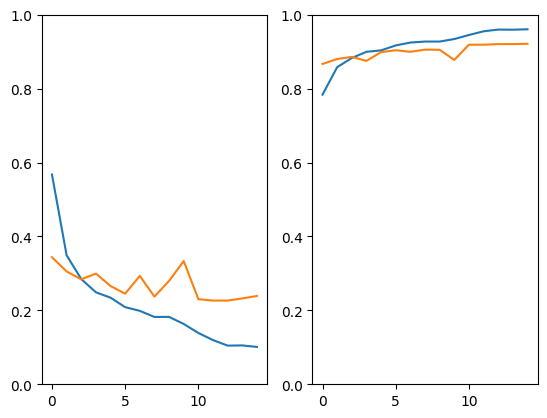

In [ ]:
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0,1))

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim((0,1))
